<a href="https://colab.research.google.com/github/Mouez-Yazidi/LLM-GenAI-Solutions-Notebooks/blob/master/Low-Code%20AI%20Text%20Labeling%20Tool%20with%20Gemma%203%2C%20Python%2C%20and%20Ollama/Low_Code_AI_Text_Labeling_Tool_with_Gemma_3%2C_Python%2C_and%C2%A0Ollama.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

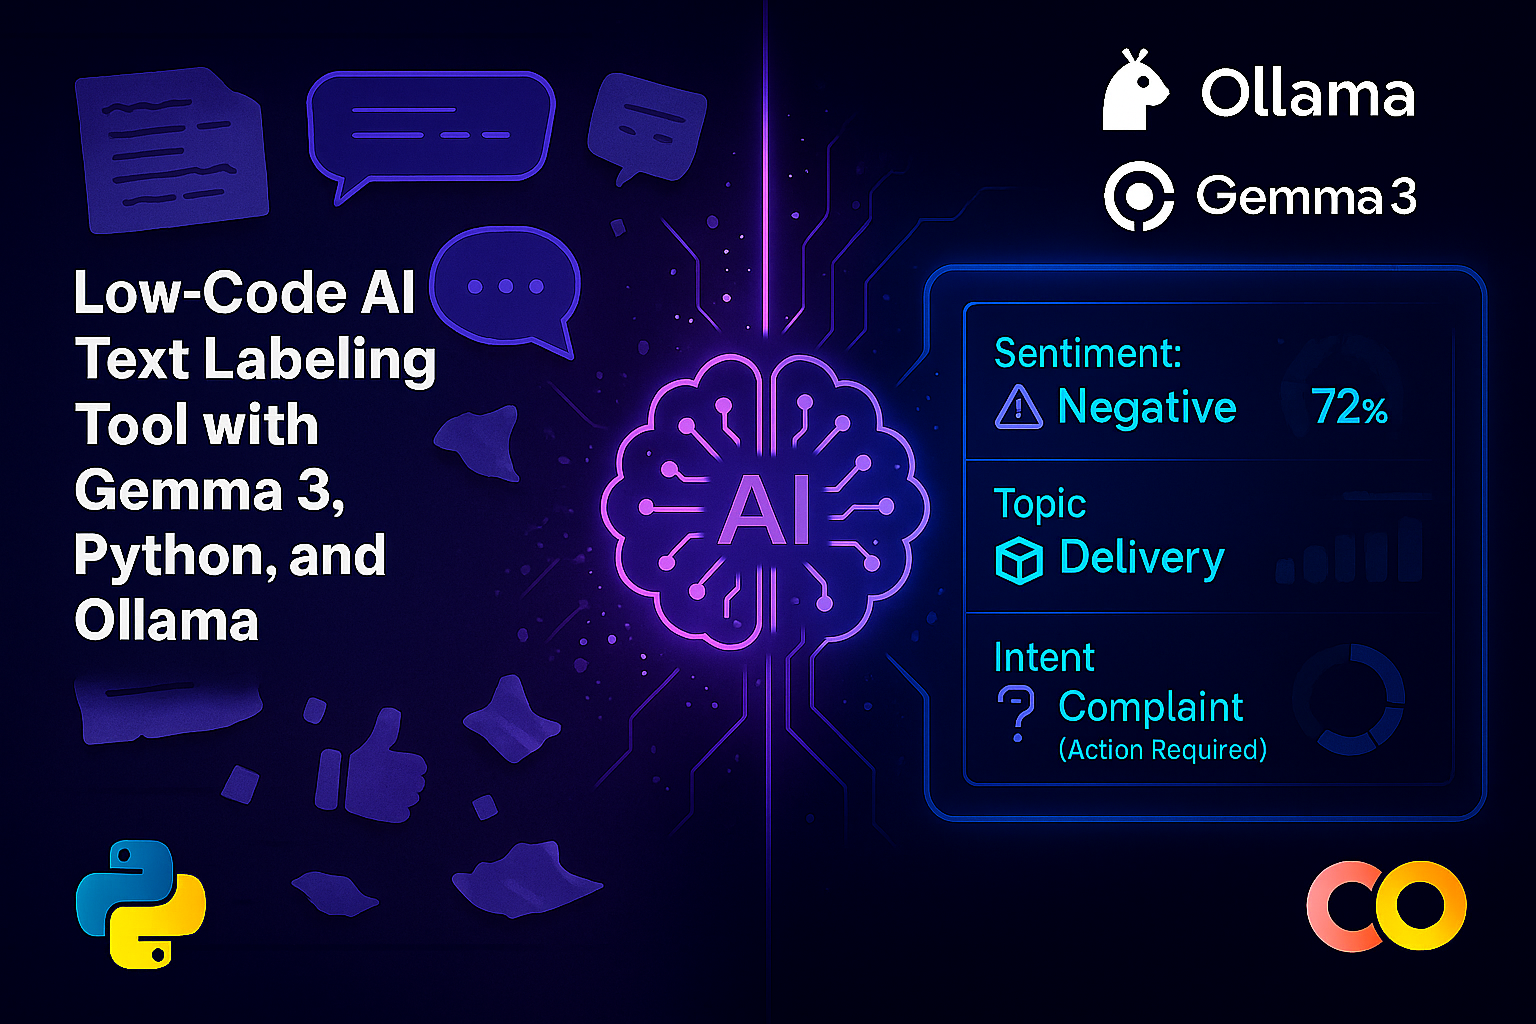

# **install olama**

In [ ]:
!pip install colab-xterm
%load_ext colabxterm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.6/115.6 kB 4.2 MB/s eta 0:00:00


In [ ]:
#curl -fsSL https://ollama.com/install.sh | sh
# ollama serve & ollama pull gemma3:4b

In [ ]:
%xterm

Launching Xterm...

<IPython.core.display.Javascript object>

In [ ]:
!ollama list

NAME         ID              SIZE      MODIFIED       
gemma3:4b    a2af6cc3eb7f    3.3 GB    10 seconds ago    


# **Building the Classification Prompt: Getting Clean JSON Responses from the Model**

In [ ]:
!pip install litellm -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 62.1 MB/s eta 0:00:00


In [ ]:
import litellm
import json
import re
def classify_text(input_text: str, labels: list[str]):
    # System and user messages with clear JSON formatting instruction
    system_prompt = (
    "You are a professional text classification model. "
    "Your job is to classify user-provided text into one of the predefined categories. "
    "Always return a JSON object in the following format: {\"label\": \"<predicted_label>\"}. "
    "Never explain or add anything outside the JSON structure. The label must exactly match one of the given categories."
    )
    user_prompt = f"""
    Given the following list of categories: {', '.join(labels)}.

    Classify the text below into one of these categories. Only respond with a valid JSON object in this format:
    {{"label": "<category>"}}.

    Do not provide explanations or commentary. Use only the category name that best fits the text.

    Text to classify:
    \"\"\"{input_text}\"\"\"
    """

    response = litellm.completion(
        model="ollama/gemma3:4b",
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ]
    )

    content = response['choices'][0]['message']['content'].strip()
    try:
        content = re.sub(r'^```json|```$', '', content, flags=re.MULTILINE).strip()
        result = json.loads(content)
        return result
    except json.JSONDecodeError:
        return {"label": "Unknown", "error": "Could not parse JSON"}

# **Load the dataset**

I choose dataset from Kaggle: [Text Document Classification](https://www.kaggle.com/datasets/sunilthite/text-document-classification-dataset) Dataset, which contains 2225 text data and five categories of documents. **Five categories are politics, sport, tech, entertainment and business.**


In [ ]:
import pandas as pd
df = pd.read_csv("/content/df_file.csv")

#choose 20 random rows for testing
df1 = df.sample(20)

In [ ]:
# Define a mapping dictionary where each numeric label corresponds to a category name.
label_map = {
    0: "Politics",
    1: "Sport",
    2: "Technology",
    3: "Entertainment",
    4: "Business"
}

# Replace the numeric values in the 'Label' column of df1 with their corresponding category names using the mapping.
df1["Label"] = df1["Label"].map(label_map)

In [ ]:
df1

,Text,Label
258,Hewitt decries 'career sexism'\n \n Plans to e...,Politics
1528,Elton plays Paris charity concert\n \n Sir Elt...,Entertainment
1941,WMC says Xstrata bid is too low\n \n Australia...,Business
1606,Singer Ian Brown 'in gig arrest'\n \n Former S...,Entertainment
1906,Marsh executive in guilty plea\n \n An executi...,Business
707,Radcliffe proves doubters wrong\n \n This won'...,Sport
1432,Little Britain two top comic list\n \n Little ...,Entertainment
732,Robertson out to retain Euro lure\n \n Hearts ...,Sport
1461,US show sued for rat-eating stunt\n \n A US TV...,Entertainment
327,"UK heading wrong way, says Howard\n \n Tony Bl...",Politics


# **Sample Predictions: Evaluating LLM Performance on Real Data**

In [ ]:
# Extract the unique labels from the 'Label' column of the dataframe df1,
# and convert them to a list. This list will be used as possible categories for classification.
categories = df1['Label'].unique().tolist()

# Apply the classify_text function to each text entry in the 'Text' column of df1.
# For each text, classify_text returns a dictionary with a 'label' key.
# Extract the 'label' value and assign it to a new column 'predicted_class' in df1.
df1['predicted_class'] = df1['Text'].apply(lambda x: classify_text(x, categories)['label'])

In [ ]:
df1

,Text,Label,predicted_class
258,Hewitt decries 'career sexism'\n \n Plans to e...,Politics,Politics
1528,Elton plays Paris charity concert\n \n Sir Elt...,Entertainment,Entertainment
1941,WMC says Xstrata bid is too low\n \n Australia...,Business,Business
1606,Singer Ian Brown 'in gig arrest'\n \n Former S...,Entertainment,Entertainment
1906,Marsh executive in guilty plea\n \n An executi...,Business,Business
707,Radcliffe proves doubters wrong\n \n This won'...,Sport,Sport
1432,Little Britain two top comic list\n \n Little ...,Entertainment,Entertainment
732,Robertson out to retain Euro lure\n \n Hearts ...,Sport,Politics
1461,US show sued for rat-eating stunt\n \n A US TV...,Entertainment,Entertainment
327,"UK heading wrong way, says Howard\n \n Tony Bl...",Politics,Politics


# **Deploy a Text Annotation Tool with Gradio on Google Colab**

In [ ]:
import gradio as gr
import pandas as pd
import io
import json
import litellm
import tempfile
import os
import re

LABELS = ["Politics", "Sport", "Technology", "Entertainment", "Business"]

def classify_text(input_text: str, labels: list[str]):
    # System and user messages with clear JSON formatting instruction
    system_prompt = (
    "You are a professional text classification model. "
    "Your job is to classify user-provided text into one of the predefined categories. "
    "Always return a JSON object in the following format: {\"label\": \"<predicted_label>\"}. "
    "Never explain or add anything outside the JSON structure. The label must exactly match one of the given categories."
    )
    user_prompt = f"""
    Given the following list of categories: {', '.join(labels)}.

    Classify the text below into one of these categories. Only respond with a valid JSON object in this format:
    {{"label": "<category>"}}.

    Do not provide explanations or commentary. Use only the category name that best fits the text.

    Text to classify:
    \"\"\"{input_text}\"\"\"
    """

    response = litellm.completion(
        model="ollama/gemma3:4b",
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ]
    )

    content = response['choices'][0]['message']['content'].strip()
    try:
        content = re.sub(r'^```json|```$', '', content, flags=re.MULTILINE).strip()
        result = json.loads(content)
        return result
    except json.JSONDecodeError:
        return {"label": "Unknown", "error": "Could not parse JSON"}

# Global state
uploaded_df = pd.DataFrame()

def load_csv(file):
    global uploaded_df
    if file is None:
        return pd.DataFrame(), gr.update(choices=[], value=None)

    uploaded_df = pd.read_csv(file.name)
    column_names = uploaded_df.columns.tolist()
    return uploaded_df, gr.update(choices=column_names, value=column_names[0] if column_names else None)

def annotate_and_show(column_name):
    global uploaded_df
    if column_name not in uploaded_df.columns:
        return "Invalid column", None

    df_copy = uploaded_df.copy()
    df_copy['Predicted_Label'] = df_copy[column_name].astype(str).apply(
        lambda x: classify_text(x, LABELS)['label']
    )

    # Save to a temporary CSV file
    tmp_file = tempfile.NamedTemporaryFile(delete=False, suffix=".csv", mode='w', newline='', encoding='utf-8')
    df_copy.to_csv(tmp_file.name, index=False)
    tmp_file.close()  # Close so Gradio can access it

    return df_copy, tmp_file.name

# Gradio UI
with gr.Blocks() as app:
    gr.Markdown("## 🧠 LLM-Powered Text Classification Annotator")

    with gr.Row():
        with gr.Column(scale=1):
            file_input = gr.File(label="📄 Upload CSV")
            column_dropdown = gr.Dropdown(label="Select Column to Annotate", choices=[], interactive=True)
            load_button = gr.Button("🔁 Load Columns")
            annotate_button = gr.Button("🪄 Annotate Text with LLM")

        with gr.Column(scale=2):
            output_table = gr.Dataframe(label="🧾 Annotated Data")
            download_csv = gr.File(label="⬇️ Download Annotated CSV", interactive=False)

    load_button.click(
        fn=load_csv,
        inputs=file_input,
        outputs=[output_table, column_dropdown]
    )
    annotate_button.click(
        fn=annotate_and_show,
        inputs=column_dropdown,
        outputs=[output_table, download_csv]
    )

app.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://5c7cdfa79ed088781a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
